In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split




import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassAccuracy

from collections import Counter
#import torchivision.datasets as dsets


from sklearn.metrics import (auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve, 
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    )

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this notebook I explore the dataset [Vertebral_Column]( https://archive.ics.uci.edu/dataset/212/vertebral+column)

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
vertebral_column = fetch_ucirepo(id=212) 
  
# data (as pandas dataframes) 
X = vertebral_column.data.features 
y = vertebral_column.data.targets 
  
# metadata 
print(vertebral_column.metadata) 
  
# variable information 
print(vertebral_column.variables) 


{'uci_id': 212, 'name': 'Vertebral Column', 'repository_url': 'https://archive.ics.uci.edu/dataset/212/vertebral+column', 'data_url': 'https://archive.ics.uci.edu/static/public/212/data.csv', 'abstract': 'Data set containing values for six biomechanical features used to classify orthopaedic patients into 3 classes (normal, disk hernia or spondilolysthesis) or 2 classes (normal or abnormal).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 310, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2005, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C5K89B', 'creators': ['Guilherme Barreto', 'Ajalmar Neto'], 'intro_paper': None, 'additional_info': {'summary': "Biomedical data set built by Dr. Henrique da Mota during a medical residence period in the Group of Applied R

## Data exploration

In [5]:
type(X)

pandas.core.frame.DataFrame

In [6]:
X.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


In [7]:
X.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


The dataset consists of 6 features and has 310 samples as shown in the tables above. There are not null values. The target consists of 3 classes:

In [8]:
type(y) 

pandas.core.frame.DataFrame

In [9]:
y["class"].unique()

array(['Hernia', 'Spondylolisthesis', 'Normal'], dtype=object)

In [10]:
num_class = y["class"].value_counts()
num_class

class
Spondylolisthesis    150
Normal               100
Hernia                60
Name: count, dtype: int64

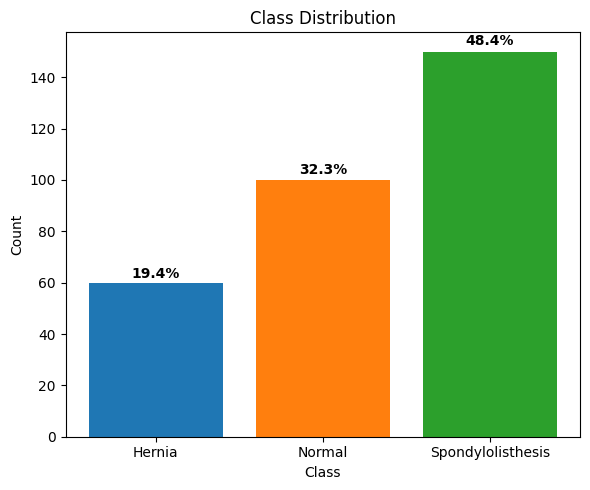

In [11]:
counts = y["class"].value_counts().sort_index()


# counts and percentages
labels = counts.index
values = counts.values
percentages = values / values.sum() * 100

colors = ["tab:blue", "tab:orange", "tab:green"]  # one per class
plt.figure(figsize=(6,5))
bars = plt.bar(labels, values,  color=colors)

# add text above bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height * 1.01,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.tight_layout()
plt.show()



## Preprocessing 

Most ML / DL libraries (PyTorch, NumPy, scikit-learn) work directly with NumPy arrays or tensors. Column names are no longer needed for training therefore one has to transform the pandas dataframe into numpy arrays:

In [12]:
######################################
# passig pandas arrays to numpy arrays
######################################

X = X.values                           # shape: (N, d)
y = y["class"].values                  # shape: (N,)



Before:
X → DataFrame (N × d)
y → DataFrame (N × 1)

After:
X → NumPy array (N × d)
y → NumPy array (N,)


In [13]:
#############################################
# labeling classes
#############################################
le = LabelEncoder()
y = le.fit_transform(y)

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mapping:", label_mapping)


Label Mapping: {'Hernia': 0, 'Normal': 1, 'Spondylolisthesis': 2}


Next, the  train/val/test split has to be done. Since the dataset is moderate imbalaced, "random_split" command does not garantee the unbiased model evaluation, also it does not preserves class distribution. Therefore, I use a two-step stratified procedure. 
Since the dataset is small, I first consider the split train/val/test -> 60%, 24%, 16%. 

In [14]:
#############################################
# Train/val/test split
#############################################

# first split: train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,       # training size, 60 %
    stratify=y,          #keeps class proportions the same
    random_state=42
)

# second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.4,      # 24% val and 16% test
    stratify=y_temp,
    random_state=42
)


In [15]:
#############################################
# normalizing features
#############################################

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit only on the train
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


In [16]:
#############################################
# convert to tensors
#############################################

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [17]:
#############################################
# create datasets 
#############################################

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)


In [18]:
len(test_dataset)

50

In [19]:


print("Train:", Counter(y_train.tolist()))
print("Val:  ", Counter(y_val.tolist()))
print("Test: ", Counter(y_test.tolist()))


Train: Counter({2: 90, 1: 60, 0: 36})
Val:   Counter({2: 36, 1: 24, 0: 14})
Test:  Counter({2: 24, 1: 16, 0: 10})


## NN model



In [20]:
#############################################
# create dataloaders
#############################################

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


Next, I define a class for a very simple neural network  with 2 hidden layers and an outlayer for multiclass classifier. 

In [28]:
class VertebralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(16,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(8, 3)  # 3 classes
        )

    def forward(self, x):
        return self.net(x)


In [29]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def validate(model, dataloader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total


Class weights: tensor([0.0278, 0.0167, 0.0111])


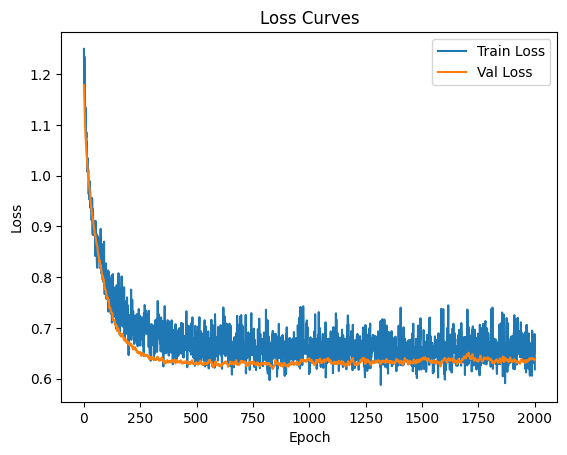

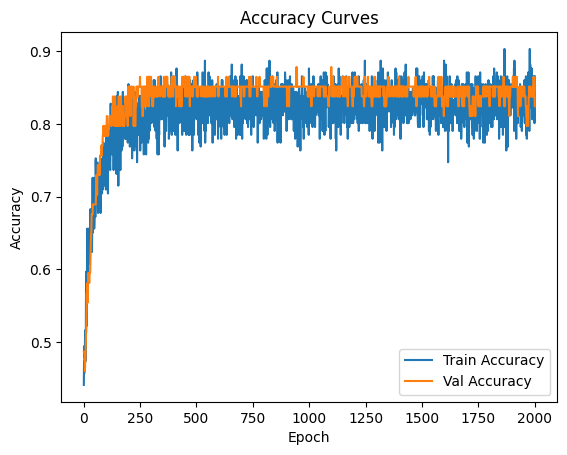

In [30]:
#################################
# Class Weights
#################################

class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts

class_weights = torch.tensor(
    class_weights, dtype=torch.float32
).to(device)

print("Class weights:", class_weights)

# class weights normalization 
class_weights = class_weights / class_weights.sum() * len(class_weights)

################################
# training
################################

model = VertebralNet().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4,weight_decay = 1e-2)

num_epochs = 2000

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    va_loss, va_acc = validate(
        model, val_loader, criterion, device
    )

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    #print(
     #   f"Epoch {epoch+1:03d} | "
      #  f"Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.3f} | "
       # f"Val Loss: {va_loss:.4f}, Acc: {va_acc:.3f}"
    #)
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()


In [31]:
def test_model_with_probs(model, dataloader, device):
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            logits = model(X)                     # shape of the tensor(Batch size, 3)
            probs = torch.softmax(logits, dim=1)  # probabilities

            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    y_true = torch.cat(all_labels).numpy()
    pred_list = torch.cat(all_preds).numpy()
    prob_list = torch.cat(all_probs).numpy()

    return y_true, pred_list, prob_list


In [32]:
y_true, pred_list, prob_list = test_model_with_probs(
    model, test_loader, device
)

accuracy = accuracy_score(y_true=y_true, y_pred=pred_list)
print(f"Accuracy: {accuracy:.4f}")

roc_auc = roc_auc_score(
    y_true=y_true,
    y_score=prob_list,
    multi_class="ovr",
    average="macro"
)

print(f"ROC-AUC (OvR, macro): {roc_auc:.4f}")



Accuracy: 0.8000
ROC-AUC (OvR, macro): 0.9340


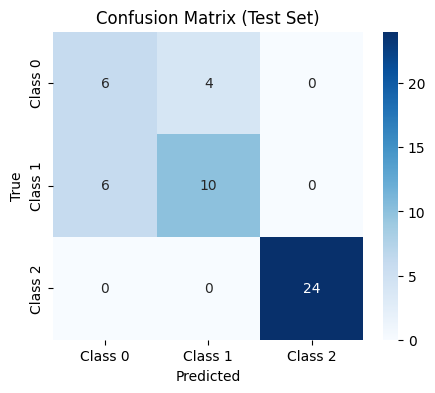

In [33]:
cm = confusion_matrix(y_true=y_true, y_pred=pred_list)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [34]:
#########################################
# Using PCA for a 2D decision region plot 
#########################################

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)


x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]



grid_original = pca.inverse_transform(grid_pca)


In [35]:


model.eval()

with torch.no_grad():
    grid_tensor = torch.tensor(
        grid_original, dtype=torch.float32
    ).to(device)

    logits = model(grid_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()


Z = preds.reshape(xx.shape)


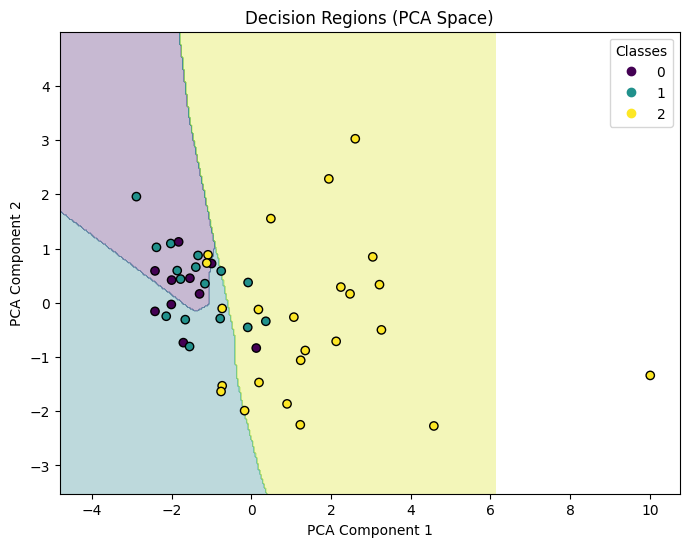

In [36]:
###################
#  plot the region
###################

plt.figure(figsize=(8, 6))

# Decision regions
plt.contourf(
    xx, yy, Z,
    alpha=0.3
)

# Training points
scatter = plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=y_test,
    edgecolor="k"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Regions (PCA Space)")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


## References:

1. Barreto, G. & Neto, A. (2005). Vertebral Column [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K89B.
2. IBM Course: Deep Learning with PyTorch at Coursera.
3. [CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
4. [How to use Learning Curves to Diagnose Machine Learning Model Performance](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)
5. Parts of the code were inspired  by examples provided at the IBM Course, while others were and some other were written with the help of ChatGPT. 